In [1]:
import sparse
import subprocess
import shlex
import pandas as pd
import numpy as np

import glob
import os
import wget
import requests
import glob
import time
import dask
import h5py


from datasketch import MinHashLSHForest, WeightedMinHash , MinHash
#Ntaxa known. avoid allvsall
from datasketch import WeightedMinHashGenerator
import dask.array as da 


from Bio import SeqIO
import pickle
import sys
sys.setrecursionlimit( 10 **9 )
from sklearn.cluster import *
from sklearn.metrics import roc_curve , precision_recall_curve , auc

import scipy
import copy
from numpy import linalg as LA
from matplotlib import pyplot as plt
import random
import h5py
import itertools
import dendropy
import os
import psutil
import seaborn as sns


overwrite = False
jk_iterations = 5
os.environ['MKL_ENABLE_INSTRUCTIONS'] = 'AVX2'

In [2]:
filedir = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/'

files = glob.glob( '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/apr_4_2022/mmsa_2022-04-04/2022-04-04_masked.fa_02022-06-14T07:53:44.200443small_test_coevmats.pkl')
print(files)
#treefile = '../validation_data/covid19/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.aln.EPIID.treefile'
#alnfile = '../validation_data/covid19/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.aln'
alnfile = filedir + 'datasets/covid_data/msa_0730/msa_0730.fasta'

treefile = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/feb_2021/GISAID-hCoV-19-phylogeny-2021-02-21/global.tree'
modeldir = filedir+'datasets/covid_data/structs/'

alnh5 = alnfile+'.h5'
#ts = '2021-08-08T11:16:34.358764'
#ts = '2021-08-08T14:37:59.736512'
#events = alnfile+'*'+ts+'*'
eventmats = files

['/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/apr_4_2022/mmsa_2022-04-04/2022-04-04_masked.fa_02022-06-14T07:53:44.200443small_test_coevmats.pkl']


In [3]:
nucleotide_mutation = None
AA_mutation = None
for mat in eventmats:
    with open( mat , 'rb') as pklin:
        mats = pickle.loads(pklin.read())
        print(mats)
        if AA_mutation is None:
            nucleotide_mutation = mats[1]
            AA_mutation = mats[0]
        else:
            nucleotide_mutation += mats[1]
            AA_mutation += mats[0]
print(nucleotide_mutation)
print(AA_mutation)

(<COO: shape=(741326, 29891, 380), dtype=float64, nnz=93228, fill_value=0.0>, <COO: shape=(741326, 29891, 12), dtype=float64, nnz=156073, fill_value=0.0>)
<COO: shape=(741326, 29891, 12), dtype=float64, nnz=156073, fill_value=0.0>
<COO: shape=(741326, 29891, 380), dtype=float64, nnz=93228, fill_value=0.0>


In [4]:
tree = dendropy.Tree.get( path=treefile, schema='newick' )

In [5]:
#setup the internal nodes for the fitch algo
for i,l in enumerate(tree.nodes()):
    l.event = {}
    l.scores = {}
    l.symbols = None
    l.char= None
    l.matrow = i
    

In [6]:

if os.path.exists( alnfile + '_IDs.pkl'):
    with open( alnfile + '_IDs.pkl' , 'rb') as idxin:
        IDindex = pickle.loads(idxin.read())
    IDs = dict(zip( IDindex.values() , IDindex.keys() ) )
else:
    
    msa = SeqIO.parse(alnfile , format = 'fasta')
    def clipID(ID):
        return ''.join( [ s +'|' for s in str(ID).split('|')[:-1] ])[:-1].replace('_',' ') 
    IDs = {i:rec.id for i,rec in enumerate(msa)}
    IDindex = dict(zip( IDs.values() , IDs.keys() ) )
    print( [(t,IDindex[t]) for t in list(IDindex.keys())[0:10]] )
    with open( alnfile + '_IDs.pkl' , 'wb') as idxout:
        idxout.write(pickle.dumps(IDindex))

In [7]:
AAmat = AA_mutation.sum(axis = 2).to_scipy_sparse()

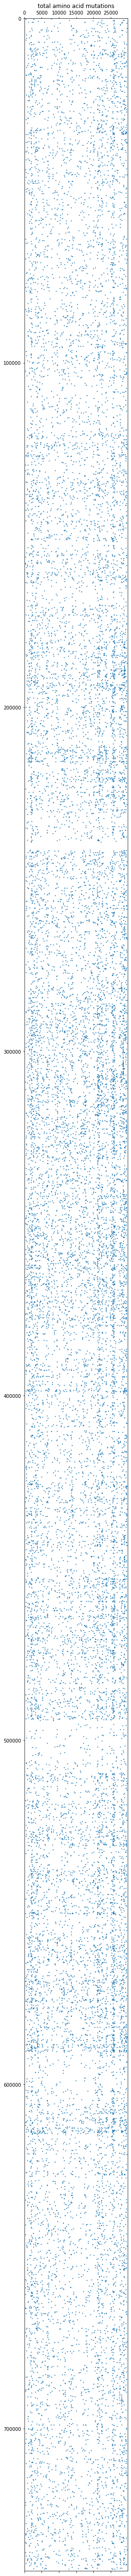

In [8]:
plt.figure(figsize=(10,100))
plt.spy(AAmat, markersize= .5)
plt.title('total amino acid mutations')
plt.show()

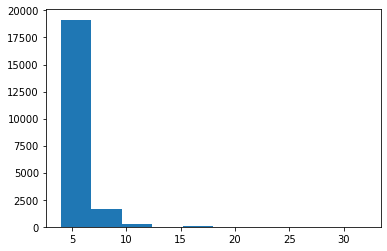

In [9]:
colsum = AAmat.sum(axis = 1)
colsum = colsum[colsum>1]

plt.hist(colsum.flat )
plt.show()

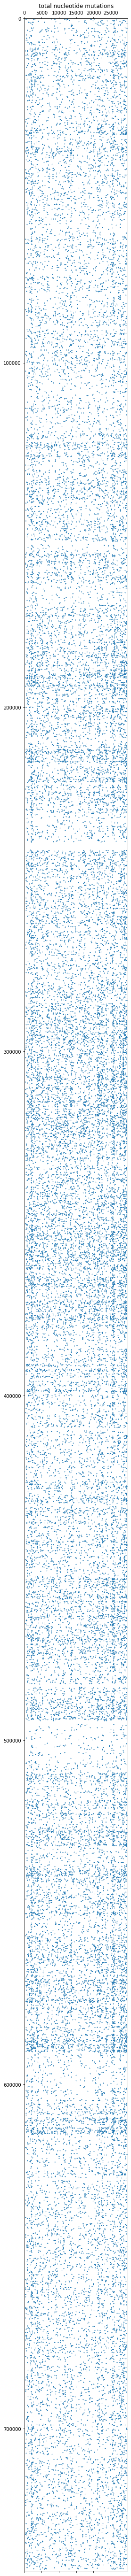

In [10]:
NT_mat = nucleotide_mutation.sum(axis = 2).to_scipy_sparse()
plt.figure(figsize=(10,100))
plt.spy(NT_mat, markersize= .5)
plt.title('total nucleotide mutations')
plt.show()

741326
nodes


/users/dmoi/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


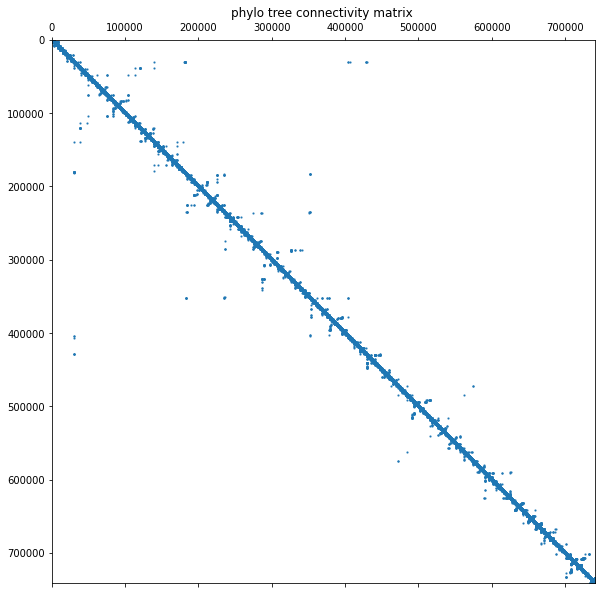

In [11]:
for i,n in enumerate(tree.nodes()):
    n.matrow = i
    n.symbols = None
    n.scores = None
    n.event = None
    n.char = None

matsize = len(tree.nodes())
print(matsize)
print('nodes')
#blur w connectivity mat
blurfactor =  .25
connectmat = scipy.sparse.csc_matrix((len(tree.nodes()), len(tree.nodes() ) ) )
index = np.array([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
lengths = np.array([ c.edge_length for n in tree.nodes() for c in n.child_nodes()])
total_len = np.sum(lengths)
#fill diagonal
#index = np.vstack( [index , np.array([ [n.matrow, n.matrow ] for n in tree.nodes() ]) ] )

connectmat[index[:,0],index[:,1]] = 1
connectmat[index[:,1],index[:,0]] = 1


#connectmat = connectmat.todense()
diag = [ i for i in range(connectmat.shape[0])]
connectmat[diag,diag] = 1
#connectmat = connectmat.todense()
#connectmat = scipy.sparse.csc_matrix(connectmat)
#np.fill_diagonal(connectmat , 1)
connectmat = scipy.sparse.coo_matrix(connectmat)
plt.figure( figsize=(10,10))
plt.title( 'phylo tree connectivity matrix ' )
plt.spy(connectmat, markersize= 1)
plt.show()

In [12]:
struct_annot = alnfile+'struct_blastout.txt'

proteo_annot  = alnfile +'annotation.csv'


annotations = pd.read_csv(  struct_annot , header = None )
annotationp = pd.read_csv(  proteo_annot , header = 0 )

annotationsp = annotationp.drop(columns = ['prots', 'genes', 'Unnamed: 0'])

annotations.columns = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ] 
annotations['struct'] = annotations.sseqid.map( lambda x : x.split(':')[0].split('/')[-1].replace('.pdb','') )
annotations['chain'] = annotations.sseqid.map( lambda x : x.split(':')[1] )
annotations['file'] = 'strucutres'

annotationp['file'] = 'proteome'

print(annotations)
print(annotationp)
annotation = pd.concat([annotations, annotationp])


annotation = annotation[ annotation['evalue'] < 10**-3 ]

annotation['coords'] = list(zip( annotation.qstart , annotation.qend ) )
annotation.sort_values('qstart')
print(annotation)

   qseqid                                             sseqid   qlen  slen  \
0     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
1     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
2     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
3     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1060   
4     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1054   
..    ...                                                ...    ...   ...   
88    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    87   
89    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    85   
90    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    85   
91    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    81   
92    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    70   

    qstart   qend  qframe        evalue struct chain        file  
0    216

In [13]:
sub = annotation.drop_duplicates(subset=['coords'])
codons = []
for idx, row in annotation.iterrows():
    codons+= [ c for c in range(row.qstart-1,row.qend-1,3)]
codons = list( set(codons) )
codons = sorted(codons)


In [14]:
print('flatten matrix ' ) 
AA_mat = AA_mutation.sum(axis = 2)
NT_mat = nucleotide_mutation.sum(axis = 2)

flatten matrix 


In [15]:
###rewrite codon compilation for sparse
import sparse

def retcodons( AAmat , NTmat,codons, verbose = True ):
    #aa mutations for each pos
    AAmat_sub = sparse.stack(  [ AAmat[ : , codon:codon+2 ].sum(axis = 1) for codon in codons  ] , axis = 1 )    
    #add the frames for each in a stack 
    if verbose == True:
        print('done AA')
    NTmat_sub = sparse.stack([  sparse.stack( [ NTmat[:, codon + frame ] for frame in [0,1,2] ] , axis = 1 )  for codon in codons ] , axis = 1)
    if verbose == True:
        print('done NT')
    return AAmat_sub , NTmat_sub
codonmat =  retcodons( AA_mat , NT_mat, codons )
print(codonmat)

done AA
done NT
(<COO: shape=(741326, 9604), dtype=float64, nnz=85404, fill_value=0.0>, <COO: shape=(741326, 9604, 3), dtype=float64, nnz=153441, fill_value=0.0>)


In [16]:
print(annotation)
structmats = {}
start_stop ={}
print(nucleotide_mutation)
print(AA_mutation)

      qseqid                                             sseqid   qlen  slen  \
0        EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
1        EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
2        EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
3        EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1060   
4        EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1054   
..       ...                                                ...    ...   ...   
33  testgeno                                     YP_009724394.1  29809    61   
34  testgeno                                     YP_009724395.1  29809   121   
35  testgeno                                     YP_009724396.1  29809   121   
36  testgeno                                     YP_009724397.2  29809   419   
37  testgeno                                     YP_009725255.1  29809    38   

    qstart   qend  qframe        evalue

In [17]:

# WeightedMinHashGenerator requires dimension as the first argument
#flatten aa mat


print('done' )
def blur_cols( mat , blurmat , niter = 10 , distributed = True ):
    for i in range(niter):
        print(i)
        mat += blurmat.dot(mat)
    return mat
#transform dask array
#AAmat_dask = da.from_array(AA_mat)
#blurmat = da.from_array(connectmat)
print('blurring')
AA_blurmmat = blur_cols(codonmat[0].to_scipy_sparse(), connectmat, 25 )
NT_blurmmat = blur_cols(codonmat[1].sum(axis = 2).to_scipy_sparse(), connectmat, 10 )

done
blurring
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9


In [18]:
print(AA_blurmmat)

  (0, 963)	1.0
  (0, 964)	1.0
  (0, 965)	1.0
  (0, 966)	1.0
  (0, 7273)	1343.0
  (0, 7274)	1343.0
  (0, 621)	1293.0
  (0, 622)	2586.0
  (0, 623)	1293.0
  (0, 4662)	314422.0
  (0, 4663)	314422.0
  (0, 4664)	314422.0
  (0, 4665)	314422.0
  (0, 6360)	314424.0
  (0, 6361)	314424.0
  (0, 6362)	314424.0
  (0, 6363)	314424.0
  (0, 4935)	314422.0
  (0, 4936)	314422.0
  (0, 4937)	314422.0
  (0, 4938)	314422.0
  (0, 815)	34634283.0
  (0, 816)	34634283.0
  (0, 817)	34634283.0
  (0, 818)	34634283.0
  :	:
  (741325, 7033)	19737099034.0
  (741325, 7034)	19737099034.0
  (741325, 7035)	19737099034.0
  (741325, 4192)	310074596774.0
  (741325, 4193)	310074596774.0
  (741325, 4194)	310074596774.0
  (741325, 4195)	310074596774.0
  (741325, 1846)	53173572962180.0
  (741325, 1845)	53173572962180.0
  (741325, 1844)	53173572962180.0
  (741325, 1843)	53173572962180.0
  (741325, 958)	81841985340.0
  (741325, 957)	81841985340.0
  (741325, 956)	81841985340.0
  (741325, 955)	81841985340.0
  (741325, 6782)	43412492

In [19]:
def val2interval(val, interval = 2 , log = True):
        if log == True:
            val = np.log(val)
        val = int(val)
        return [ str(r) for r in range(0,val,interval)  ]

def hash_cols( cols  ):
    for dset in cols:
        col = cols[dset]

        nz = list( col.nonzero()[0])
        d = list(col.data)

        mh = MinHash(num_perm=256 , seed = 0 )
        [mh.update( (str(e) + v +dset ).encode() ) for e,d in zip( nz, d ) for v in val2interval(d , interval = 1 , log = True ) ]
    return mh

maxval = AA_blurmmat.max()
print( maxval)
interval = val2interval(maxval)
print(interval)


1.1000695667017275e+29
['0', '2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32', '34', '36', '38', '40', '42', '44', '46', '48', '50', '52', '54', '56', '58', '60', '62', '64']


In [ ]:
import h5py
import multiprocessing as mp


compileDB = True

if compileDB == True:
    print('strating pool')
    pool = mp.Pool(processes=mp.cpu_count()-4 )
    print('done')

    batch = mp.cpu_count()-4
    res = []
    thiscols = []
    forest = MinHashLSHForest(num_perm=256)
    print('starting')
    mapper = {}
    revmapper = {}
    count = 0
    with h5py.File("hashsigs_AA.hdf5", "w") as f:
        dset = f.create_dataset("signatures", maxshape = (None, 256), shape=(len(codons) ,256) , dtype='int64')
        print('created dataset')
        for i,col in enumerate(codons):
            if i % 100 == 0:
                print(i, i / len(codons))
            res.append( pool.apply_async(hash_cols , [  { 'AA':AA_blurmmat[:,i]  } ] ) )
            thiscols.append(col)
            if len(res)> batch :
                res = [ r.get() for r in res ]
                for n,col in enumerate(res):
                    forest.add(thiscols[n], res[n])
                    if dset.shape[0]< count-1:
                        dset.resize((count+10 ,256 ))  
                        print(dset.shape)
                    dset[count,:] = res[n].digest()
                    mapper[count] = thiscols[n]
                    revmapper[ thiscols[n] ] =count 
                    count +=1
                    f.flush()

                res = []
                thiscols = []
        print(dset,dset[0:10],f)
    pool.close()
    with open('lshforest_AA.pkl' , 'wb') as forestout:
        forestout.write(pickle.dumps(forest))
else:

    with open('lshforest_AA.pkl' , 'rb') as forestout:
        forest = pickle.loads(forestout.read())

forest.index()
mapper = {}
for i,col in enumerate(codons):
    mapper[i]= col
revmapper = dict( zip( mapper.values(), mapper.keys()))

strating pool
done
starting
created dataset
0 0.0
100 0.010412328196584756
200 0.02082465639316951
300 0.03123698458975427
400 0.04164931278633902
500 0.05206164098292378
600 0.06247396917950854
700 0.0728862973760933
800 0.08329862557267805
900 0.0937109537692628
1000 0.10412328196584757
1100 0.11453561016243231
1200 0.12494793835901707
1300 0.13536026655560182
1400 0.1457725947521866
1500 0.15618492294877134
1600 0.1665972511453561
1700 0.17700957934194086
1800 0.1874219075385256
1900 0.19783423573511036
2000 0.20824656393169513
2100 0.21865889212827988
2200 0.22907122032486463
2300 0.2394835485214494
2400 0.24989587671803415
2500 0.2603082049146189


In [ ]:
#create a net of columns

#pull hash
def col2hash( revmap , col):
    with h5py.File("hashsigs_AA.hdf5", "r") as f:
        return MinHash(seed=0,hashvalues=f['signatures'][revmap[col],:])
def query2distances(qcol,revmapper, forest , k = 20 ):
    qhash = col2hash( revmapper , qcol)
    rescols = forest.query(qhash , k = k )
    mhs = [ col2hash(revmapper,col) for col in rescols ]
    jaccards = np.array([ qhash.jaccard( mh ) for mh in mhs ])
    #sort results
    order = np.flip(np.argsort(jaccards))
    rescols = np.array(rescols)[order]
    jaccards = jaccards[order]
    return rescols, jaccards

def build_net(cols,revmapper, forest , matshape = (30000, 30000)):
    connectmat = scipy.sparse.lil_matrix(matshape)
    cols = list(cols)
    for i,qcol in enumerate(cols):
        if i % 100 == 0 :
            print(i)
        rescol, jaccards = query2distances(qcol,revmapper, forest , k = 5 )
        connectmat[qcol,rescol] += jaccards
    connectmat+= connectmat.T
    connectmat/=2
    return scipy.sparse.coo_matrix(connectmat)

print(len(codons))
#finalset = set(np.where(colsum> 1)[1]).intersection(set(codons))
#print(len(finalset))
jaccard_connectmat = build_net( codons, revmapper, forest ,matshape = (30000, 30000))

In [ ]:
plt.hist( jaccard_connectmat.data )
plt.xlabel('n column pairs')
plt.ylabel('jaccard distance')
with open('jaccard_coevmat.pkl' , 'wb') as coevmatout:
    coevmatout.write(pickle.dumps(jaccard_connectmat)) 
plt.show()

In [ ]:
print(annotations)

In [ ]:
import itertools
from matplotlib.patches import Rectangle
from colour import Color


red = Color("red")
blue = Color("blue")
clist = [ c.hex_l for c in list(red.range_to(blue, len(annotations.struct.unique())  ) ) ]
clist = dict( zip ( list(annotations.struct.unique() ), clist ) ) 
print( clist )
fig, ax = plt.subplots()

fig.set_figheight(15)
fig.set_figwidth(15)

ax.spy( jaccard_connectmat, markersize= .2)
for struct in annotations.struct.unique():
    sub = annotations[annotations.struct == struct]
    chains = {}
    
    print(struct)
    for idx, row  in sub.iterrows():
        chains[row.chain] = {'start':row.qstart , 'stop':row.qend }
    for i , tup in enumerate(itertools.product(chains, repeat = 2)):
        c1,c2 = tup
        s1 = chains[c1]['stop'] - chains[c1]['start']                     
        s2 = chains[c2]['stop'] - chains[c2]['start']
        if i == 0:
            rect =Rectangle((chains[c1]['start'],chains[c2]['start']), s1, s2, linewidth=2, edgecolor=clist[struct], facecolor='none', label = struct)
        else:
            rect =Rectangle((chains[c1]['start'],chains[c2]['start']), s1, s2, linewidth=2, edgecolor=clist[struct], facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        rect =Rectangle((chains[c2]['start'],chains[c1]['start']), s2, s1, linewidth=2, edgecolor=clist[struct],  facecolor='none')
        ax.add_patch(rect)

plt.legend(loc = 'upper right')
plt.show()

In [ ]:
with open('jaccard_coevmat.pkl' , 'rb') as coevmatout:
    jaccard_connectmat= pickle.loads(coevmatout.read()) 

In [ ]:
thresh = .25
jaccard_connectmat = sparse.COO(jaccard_connectmat)
print(sparse.where(jaccard_connectmat > thresh)  )


coords = sparse.where(jaccard_connectmat > thresh and jaccard_connectmat > 0)




In [ ]:
print( coords[0][0:10], coords[1][0:1] )

In [ ]:
#highlight regions of contact points

col1 = AAmat[:, 29574]
col2 = AAmat[:, 29568]
print(col1,col2)

In [ ]:
import matplotlib.pyplot as plt

from tick.plot import plot_hawkes_kernels
from tick.hawkes import SimuHawkesSumExpKernels, SimuHawkesMulti, \
    HawkesSumExpKern

end_time = 1000
n_realizations = 10

decays = [.5, 2., 6.]
baseline = [0.12, 0.07]
adjacency = [[[0, .1, .4], [.2, 0., .2]],
             [[0, 0, 0], [.6, .3, 0]]]

hawkes_exp_kernels = SimuHawkesSumExpKernels(
    adjacency=adjacency, decays=decays, baseline=baseline,
    end_time=end_time, verbose=False, seed=0)

learner = HawkesSumExpKern(decays, penalty='elasticnet', elastic_net_ratio=0.8)

learner.fit([col1.coords[0].astype(np.double),col2.coords[0].astype(np.double) ])

print(dir(learner))
fig = plot_hawkes_kernels(learner, hawkes=hawkes_exp_kernels, show=False)

for ax in fig.axes:
    ax.set_ylim([0., 1.])

In [ ]:
plt.show()

In [28]:
#ROC curve on retrieved points


qseqid                                                      EPI
sseqid        /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...
qlen                                                      29809
slen                                                       1121
qstart                                                    21604
qend                                                      24966
qframe                                                        1
evalue                                                      0.0
struct                                                     7DZW
chain                                                         C
file                                                 strucutres
Unnamed: 0                                                  NaN
prots                                                       NaN
genes                                                       NaN
coords                                           (21604, 24966)
Name: 0, dtype: object


RuntimeError: Cannot convert a sparse array to dense automatically. To manually densify, use the todense method.

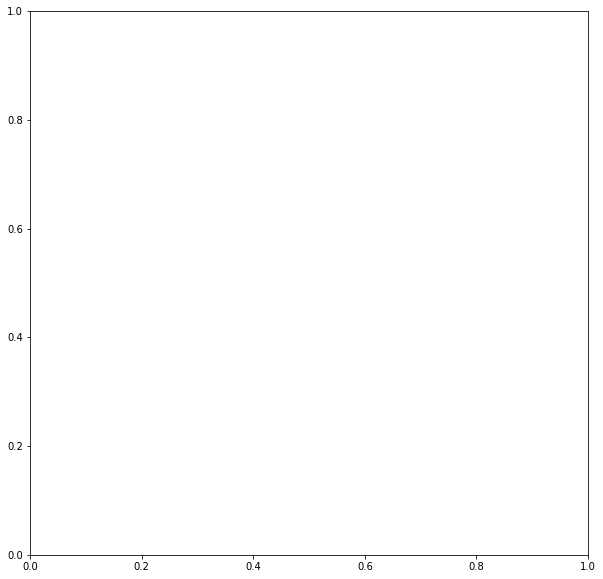

In [29]:


row = annotation.iloc[0]
print(row)
submat = jaccard_connectmat[row.qstart:row.qend,:]
submat = jaccard_connectmat[:,row.qstart:row.qend]
plt.figure(figsize= (10,10) )
plt.spy( jaccard_connectmat , markersize= 1)
plt.show()

In [ ]:
# Create a Rectangle patch



